In [21]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from typing import TypedDict
from IPython.display import Image

# BMI finding

In [22]:
#step 1
#Define state
class BMIState(TypedDict):
    weight_kg:float
    height_mtr:float
    bmi:float


def calculate_bmi(state:BMIState) -> BMIState:
    print("State received by calculate_bmi:", state)
    weight = state["weight_kg"]
    height = state["height_mtr"]
    bmi = weight/(height**2)

    state["bmi"] = round(bmi,2)

    return state


    

In [23]:
#step2
#define your graph

graph=StateGraph(BMIState)

#add node
graph.add_node('calculate_bmi',calculate_bmi)

#add edges
graph.add_edge(START,'calculate_bmi')
graph.add_edge("calculate_bmi",END)

#compile graph
workflow = graph.compile()

#execute the graph
output_state = workflow.invoke({"weight_kg":80,"height_mtr":1.73})

print(output_state)

State received by calculate_bmi: {'weight_kg': 80, 'height_mtr': 1.73}
{'weight_kg': 80, 'height_mtr': 1.73, 'bmi': 26.73}


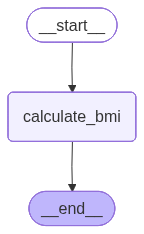

In [24]:
Image(workflow.get_graph().draw_mermaid_png())